Compare the ensemble of reconstructed inflows to the ground truth inflow.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import string
import xarray as xr

In [2]:
### Load data 
## Ground truth
parent_dir_gt = Path('/projects/wakedynamics/orybchuk/bcs-ldm/advect_interpolate/osse/processed_amrwind_obs')
f_gt0 = Path(parent_dir_gt, 'y3840', 'inflow-bc-3D.nc')
f_gt1 = Path(parent_dir_gt, 'y7680', 'inflow-bc-3D.nc')
f_gt2 = Path(parent_dir_gt, 'y11520', 'inflow-bc-3D.nc')
ds_gt0 = xr.open_dataset(f_gt0)
ds_gt1 = xr.open_dataset(f_gt1)
ds_gt2 = xr.open_dataset(f_gt2)

## Reconstruction ensemble
parent_dir_recon = Path('/projects/wakedynamics/orybchuk/bcs-ldm/palette_3d/concat_and_cascade/sampling_output')
f_recon0 = Path(parent_dir_recon, 'y3840', 'assembled_lidar_and_recons_2000_01_01_00:00:00_2000_01_01_00:11:43.nc')
f_recon1 = Path(parent_dir_recon, 'y7680', 'assembled_lidar_and_recons_2000_01_01_00:00:00_2000_01_01_00:11:43.nc')
f_recon2 = Path(parent_dir_recon, 'y11520', 'assembled_lidar_and_recons_2000_01_01_00:00:00_2000_01_01_00:11:43.nc')
ds_recon0 = xr.open_dataset(f_recon0)
ds_recon1 = xr.open_dataset(f_recon1)
ds_recon2 = xr.open_dataset(f_recon2)

## Lidar data
parent_dir_lidar = Path('/projects/wakedynamics/orybchuk/bcs-ldm/advect_interpolate/osse/processed_amrwind_obs')
f_lidar0 = Path(parent_dir_lidar, 'y3840/long-upsampled-inflow-3D.nc')
f_lidar1 = Path(parent_dir_lidar, 'y7680/long-upsampled-inflow-3D.nc')
f_lidar2 = Path(parent_dir_lidar, 'y11520/long-upsampled-inflow-3D.nc')
ds_lidar0 = xr.open_dataset(f_lidar0)
ds_lidar1 = xr.open_dataset(f_lidar1)
ds_lidar2 = xr.open_dataset(f_lidar2)

In [5]:
### Helpful parameters
klo_bc, khi_bc = 0, 24
jlo_bc, jhi_bc = 16, 48  # the _gt and _up y inds correspond to this for _recons

In [6]:
### Sync up in time
## There are two shifts:
## - The reconstructions start at 1970-01-01T03:32:41.000000000
## - I want to take the last 600 seconds of the reconstructed winds
# Sync up to the reconstructed winds
first_timestamp_of_recon = "1970-01-01T03:32:41.000000000"  # See Issue #84 in bcs-ldm for the calculation
n_time = 600  # The number of timesteps that we will analyze
shift_due_to_10_min_trim = len(ds_recon0['time']) - n_time

# Lidar shifting
tind_lag_lidar = 145
tlo_lidar_raw = tind_lag_lidar + shift_due_to_10_min_trim
thi_lidar_raw = tlo_lidar_raw + n_time
time_stride_indicies_lidar = np.arange(tlo_lidar_raw, thi_lidar_raw)

# GT shifting
n_gt_per_sec = 8
assert (ds_gt0['time'].values[1] - ds_gt0['time'].values[0]) == 1/n_gt_per_sec, "Adjust n_gt_per_sec!"
tind_lag_gt = n_gt_per_sec*161
tlo_gt_raw = tind_lag_gt + shift_due_to_10_min_trim*n_gt_per_sec
thi_gt_raw = tlo_gt_raw + n_gt_per_sec*n_time
time_stride_indicies_gt = np.arange(tlo_gt_raw, thi_gt_raw, n_gt_per_sec)

print(f"Start timestamp of raw GT data: {ds_gt0['time'].min().values}")
print(f"Start timestamp of raw lidar data: {ds_lidar0['time'].min().values}")

print()
print(f"Timestamp of first reconstruction: {first_timestamp_of_recon}")
print(f"Timestamp of first GT plane for analysis: {ds_gt0['time'].values[tind_lag_gt] - ds_gt0['time'].values[0]}")
print(f"Timestamp of first input lidar data for analysis: {ds_lidar0['time'].values[tind_lag_lidar]}")

Start timestamp of raw GT data: 12600.0
Start timestamp of raw lidar data: 1970-01-01T03:30:16.000000000

Timestamp of first reconstruction: 1970-01-01T03:32:41.000000000
Timestamp of first GT plane for analysis: 161.0
Timestamp of first input lidar data for analysis: 1970-01-01T03:32:41.000000000


In [7]:
### Clean up the datasets
coords_time = np.arange(0, n_time, 1)
coords_y = np.arange(-160, 160, 10)
coords_z = np.arange(0, 240, 10)

## Ground truth dataset
# Initialize datasets
coords_gt = {'time': coords_time,
             'y': coords_y,
             'z': coords_z}

ds_gt0_cleaned = xr.Dataset(coords=coords_gt)
ds_gt1_cleaned = xr.Dataset(coords=coords_gt)
ds_gt2_cleaned = xr.Dataset(coords=coords_gt)

# Grab data

data_gt0_velocityx = ds_gt0['velocityx'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]
data_gt0_velocityy = ds_gt0['velocityy'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]
data_gt0_velocityz = ds_gt0['velocityz'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]
data_gt0_temperature = ds_gt0['temperature'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]
data_gt0_tke = ds_gt0['tke'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]

data_gt1_velocityx = ds_gt1['velocityx'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]
data_gt1_velocityy = ds_gt1['velocityy'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]
data_gt1_velocityz = ds_gt1['velocityz'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]
data_gt1_temperature = ds_gt1['temperature'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]
data_gt1_tke = ds_gt1['tke'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]

data_gt2_velocityx = ds_gt2['velocityx'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]
data_gt2_velocityy = ds_gt2['velocityy'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]
data_gt2_velocityz = ds_gt2['velocityz'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]
data_gt2_temperature = ds_gt2['temperature'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]
data_gt2_tke = ds_gt2['tke'].values[time_stride_indicies_gt,0,jlo_bc:jhi_bc,klo_bc:khi_bc]

# Populate datasets
ds_gt0_cleaned['velocityx'] = (('time', 'y', 'z'), data_gt0_velocityx)
ds_gt0_cleaned['velocityy'] = (('time', 'y', 'z'), data_gt0_velocityy)
ds_gt0_cleaned['velocityz'] = (('time', 'y', 'z'), data_gt0_velocityz)
ds_gt0_cleaned['temperature'] = (('time', 'y', 'z'), data_gt0_temperature)
ds_gt0_cleaned['tke'] = (('time', 'y', 'z'), data_gt0_tke)

ds_gt1_cleaned['velocityx'] = (('time', 'y', 'z'), data_gt1_velocityx)
ds_gt1_cleaned['velocityy'] = (('time', 'y', 'z'), data_gt1_velocityy)
ds_gt1_cleaned['velocityz'] = (('time', 'y', 'z'), data_gt1_velocityz)
ds_gt1_cleaned['temperature'] = (('time', 'y', 'z'), data_gt1_temperature)
ds_gt1_cleaned['tke'] = (('time', 'y', 'z'), data_gt1_tke)

ds_gt2_cleaned['velocityx'] = (('time', 'y', 'z'), data_gt2_velocityx)
ds_gt2_cleaned['velocityy'] = (('time', 'y', 'z'), data_gt2_velocityy)
ds_gt2_cleaned['velocityz'] = (('time', 'y', 'z'), data_gt2_velocityz)
ds_gt2_cleaned['temperature'] = (('time', 'y', 'z'), data_gt2_temperature)
ds_gt2_cleaned['tke'] = (('time', 'y', 'z'), data_gt2_tke)

# Export
ds_gt0_cleaned.to_netcdf(Path(f_gt0.parent, 'cleaned4analysis_'+f_gt0.name))
ds_gt1_cleaned.to_netcdf(Path(f_gt1.parent, 'cleaned4analysis_'+f_gt1.name))
ds_gt2_cleaned.to_netcdf(Path(f_gt2.parent, 'cleaned4analysis_'+f_gt2.name))

# Overwrite
ds_gt0 = ds_gt0_cleaned
ds_gt1 = ds_gt1_cleaned
ds_gt2 = ds_gt2_cleaned

## Reconstruction datasets
# Initialize datasets
coords_recon = {'ens': range(30),
             'time': coords_time,
             'y': coords_y,
             'z': coords_z}

ds_recon0_cleaned = xr.Dataset(coords=coords_recon)
ds_recon1_cleaned = xr.Dataset(coords=coords_recon)
ds_recon2_cleaned = xr.Dataset(coords=coords_recon)

# Grab data
data_recon0_velocityx = ds_recon0['u_output'].data
data_recon0_velocityy = ds_recon0['v_output'].data
data_recon0_velocityz = ds_recon0['w_output'].data
data_recon0_temperature = ds_recon0['T_output'].data
data_recon0_tke = ds_recon0['TKE_output'].data

data_recon1_velocityx = ds_recon1['u_output'].data
data_recon1_velocityy = ds_recon1['v_output'].data
data_recon1_velocityz = ds_recon1['w_output'].data
data_recon1_temperature = ds_recon1['T_output'].data
data_recon1_tke = ds_recon1['TKE_output'].data

data_recon2_velocityx = ds_recon2['u_output'].data
data_recon2_velocityy = ds_recon2['v_output'].data
data_recon2_velocityz = ds_recon2['w_output'].data
data_recon2_temperature = ds_recon2['T_output'].data
data_recon2_tke = ds_recon2['TKE_output'].data

# Populate datasets
ds_recon0_cleaned['velocityx'] = (('ens', 'time', 'y', 'z'), data_recon0_velocityx[:,-1*n_time:,:,:])
ds_recon0_cleaned['velocityy'] = (('ens', 'time', 'y', 'z'), data_recon0_velocityy[:,-1*n_time:,:,:])
ds_recon0_cleaned['velocityz'] = (('ens', 'time', 'y', 'z'), data_recon0_velocityz[:,-1*n_time:,:,:])
ds_recon0_cleaned['temperature'] = (('ens', 'time', 'y', 'z'), data_recon0_temperature[:,-1*n_time:,:,:])
ds_recon0_cleaned['tke'] = (('ens', 'time', 'y', 'z'), data_recon0_tke[:,-1*n_time:,:,:])

ds_recon1_cleaned['velocityx'] = (('ens', 'time', 'y', 'z'), data_recon1_velocityx[:,-1*n_time:,:,:])
ds_recon1_cleaned['velocityy'] = (('ens', 'time', 'y', 'z'), data_recon1_velocityy[:,-1*n_time:,:,:])
ds_recon1_cleaned['velocityz'] = (('ens', 'time', 'y', 'z'), data_recon1_velocityz[:,-1*n_time:,:,:])
ds_recon1_cleaned['temperature'] = (('ens', 'time', 'y', 'z'), data_recon1_temperature[:,-1*n_time:,:,:])
ds_recon1_cleaned['tke'] = (('ens', 'time', 'y', 'z'), data_recon1_tke[:,-1*n_time:,:,:])

ds_recon2_cleaned['velocityx'] = (('ens', 'time', 'y', 'z'), data_recon2_velocityx[:,-1*n_time:,:,:])
ds_recon2_cleaned['velocityy'] = (('ens', 'time', 'y', 'z'), data_recon2_velocityy[:,-1*n_time:,:,:])
ds_recon2_cleaned['velocityz'] = (('ens', 'time', 'y', 'z'), data_recon2_velocityz[:,-1*n_time:,:,:])
ds_recon2_cleaned['temperature'] = (('ens', 'time', 'y', 'z'), data_recon2_temperature[:,-1*n_time:,:,:])
ds_recon2_cleaned['tke'] = (('ens', 'time', 'y', 'z'), data_recon2_tke[:,-1*n_time:,:,:])

# Export
ds_recon0_cleaned.to_netcdf(Path(f_recon0.parent, 'cleaned4analysis_'+f_recon0.name))
ds_recon1_cleaned.to_netcdf(Path(f_recon1.parent, 'cleaned4analysis_'+f_recon1.name))
ds_recon2_cleaned.to_netcdf(Path(f_recon2.parent, 'cleaned4analysis_'+f_recon2.name))

# Overwrite
ds_recon0 = ds_recon0_cleaned
ds_recon1 = ds_recon1_cleaned
ds_recon2 = ds_recon2_cleaned

## Reformat lidar data
coords_lidar = {'time': coords_time,
             'y': coords_y,
             'z': coords_z}

ds_lidar0_cleaned = xr.Dataset(coords_lidar)
ds_lidar1_cleaned = xr.Dataset(coords_lidar)
ds_lidar2_cleaned = xr.Dataset(coords_lidar)

data_lidar0 = np.nan * np.zeros((len(coords_time), len(coords_y), len(coords_z)))
data_lidar1 = np.nan * np.zeros((len(coords_time), len(coords_y), len(coords_z)))
data_lidar2 = np.nan * np.zeros((len(coords_time), len(coords_y), len(coords_z)))

k_lidar = 11
jlo_lidar_out = 8
jhi_lidar_out = 24
jlo_lidar_in = 2
jhi_lidar_in = jlo_lidar_in + 16

data_lidar0[:, jlo_lidar_out:jhi_lidar_out, k_lidar] = \
    ds_lidar0['U'].isel(time=time_stride_indicies_lidar, y=slice(jlo_lidar_in,jhi_lidar_in)).values.T
data_lidar1[:, jlo_lidar_out:jhi_lidar_out, k_lidar] = \
    ds_lidar1['U'].isel(time=time_stride_indicies_lidar, y=slice(jlo_lidar_in,jhi_lidar_in)).values.T
data_lidar2[:, jlo_lidar_out:jhi_lidar_out, k_lidar] = \
    ds_lidar2['U'].isel(time=time_stride_indicies_lidar, y=slice(jlo_lidar_in,jhi_lidar_in)).values.T

ds_lidar0_cleaned['velocityx'] = (('time', 'y', 'z'), data_lidar0)
ds_lidar1_cleaned['velocityx'] = (('time', 'y', 'z'), data_lidar1)
ds_lidar2_cleaned['velocityx'] = (('time', 'y', 'z'), data_lidar2)

# Overwrite
ds_lidar0 = ds_lidar0_cleaned
ds_lidar1 = ds_lidar1_cleaned
ds_lidar2 = ds_lidar2_cleaned

In [8]:
### Calculate two-dimensional wind speeds
ds_recon0['wspd_2d'] = np.sqrt(ds_recon0['velocityx']**2 + ds_recon0['velocityy']**2)
ds_recon1['wspd_2d'] = np.sqrt(ds_recon1['velocityx']**2 + ds_recon1['velocityy']**2)
ds_recon2['wspd_2d'] = np.sqrt(ds_recon2['velocityx']**2 + ds_recon2['velocityy']**2)

ds_gt0['wspd_2d'] = np.sqrt(ds_gt0['velocityx']**2 + ds_gt0['velocityy']**2)
ds_gt1['wspd_2d'] = np.sqrt(ds_gt1['velocityx']**2 + ds_gt1['velocityy']**2)
ds_gt2['wspd_2d'] = np.sqrt(ds_gt2['velocityx']**2 + ds_gt2['velocityy']**2)

In [9]:
### Calculate turbulence intensity
ds_recon0['TI'] = 100 * ds_recon0['wspd_2d'].std(('time')).mean(('y')) / ds_recon0['wspd_2d'].mean(('time', 'y'))
ds_recon1['TI'] = 100 * ds_recon1['wspd_2d'].std(('time')).mean(('y')) / ds_recon1['wspd_2d'].mean(('time', 'y'))
ds_recon2['TI'] = 100 * ds_recon2['wspd_2d'].std(('time')).mean(('y')) / ds_recon2['wspd_2d'].mean(('time', 'y'))

ds_gt0['TI'] = 100 * ds_gt0['wspd_2d'].std(('time')).mean(('y')) / ds_gt0['wspd_2d'].mean(('time', 'y'))
ds_gt1['TI'] = 100 * ds_gt1['wspd_2d'].std(('time')).mean(('y')) / ds_gt1['wspd_2d'].mean(('time', 'y'))
ds_gt2['TI'] = 100 * ds_gt2['wspd_2d'].std(('time')).mean(('y')) / ds_gt2['wspd_2d'].mean(('time', 'y'))

# Qualitative comparisons

### Top-down views

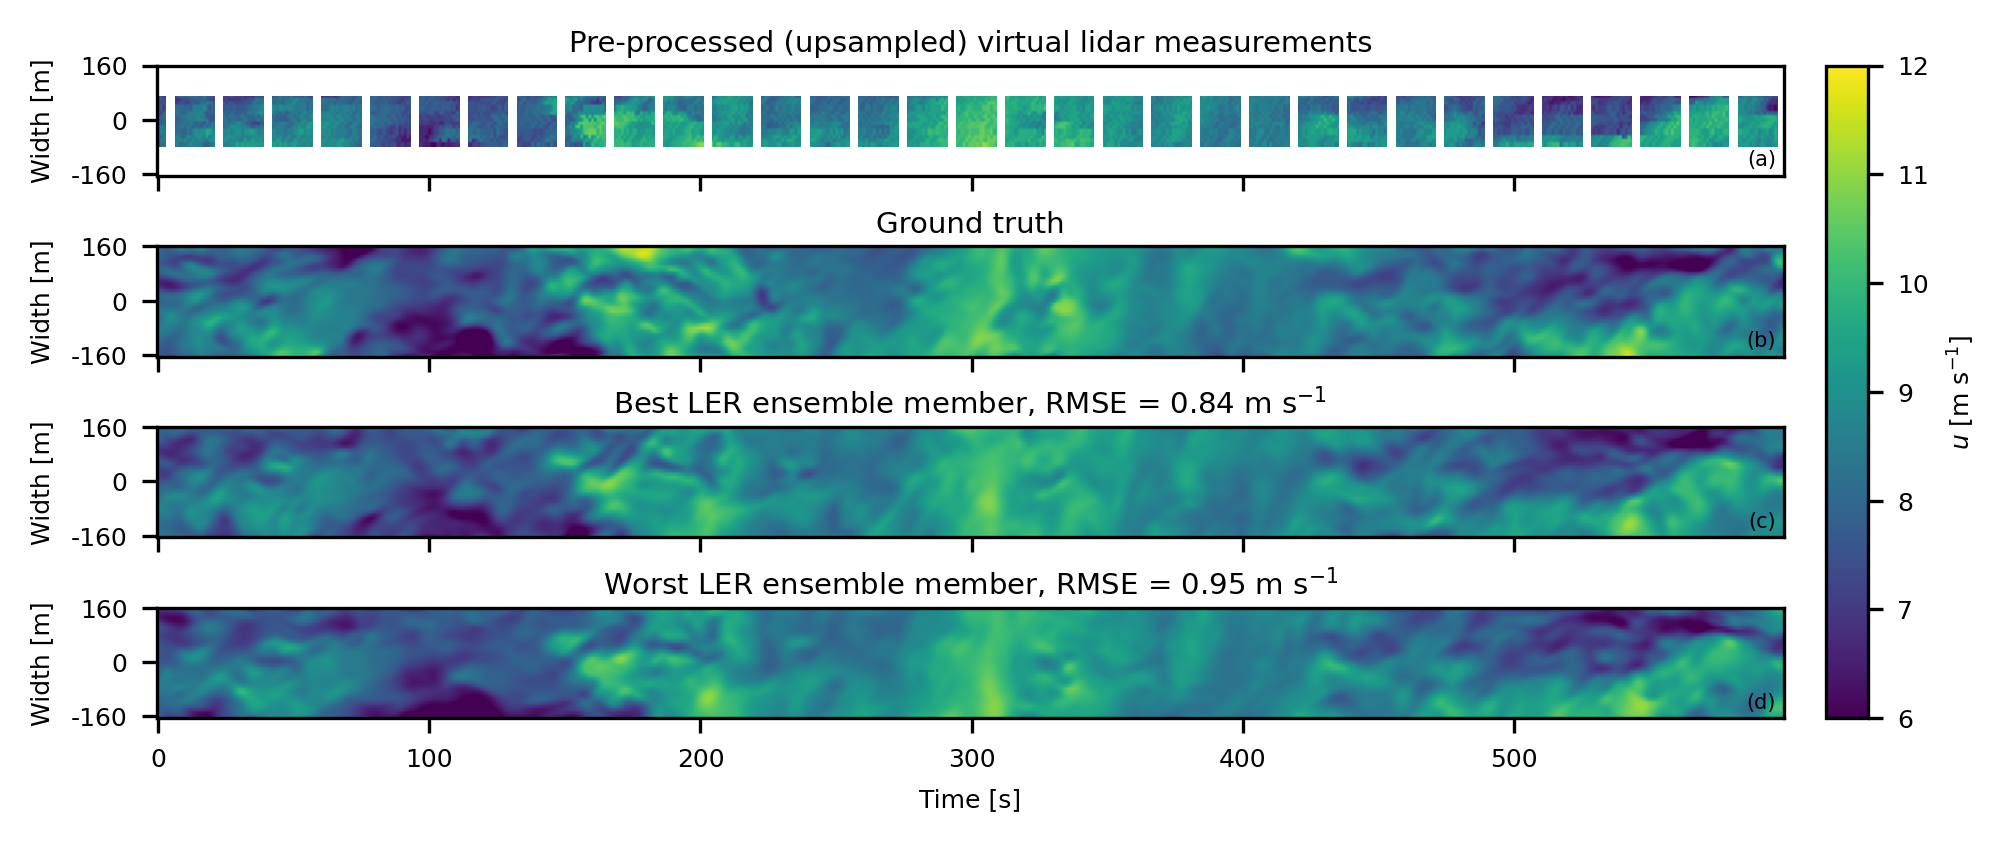

In [10]:
### Top-down views
fig, ax = plt.subplots(4, 1, figsize=(7,3), dpi=300, sharex=True)


## Plot
pltvar = 'velocityx'
pltmin, pltmax = 6, 12
ds_gt_plt = ds_gt1
ds_recon_plt = ds_recon1
ds_lidar_plt = ds_lidar1
zplt = 110
tlo = 0
thi = tlo + 600

# Calculate best/worst ensemble member
rmse_ens_plt = np.mean((ds_recon_plt[pltvar] - ds_gt_plt[pltvar])**2, axis=(1,2,3)).values
iens_best = np.argmin(rmse_ens_plt)
iens_worst = np.argmax(rmse_ens_plt)

data0 = ds_lidar_plt['velocityx'].sel(z=zplt).isel(time=slice(tlo,thi)).values
data1 = ds_gt_plt[pltvar].sel(z=zplt).isel(time=slice(tlo,thi)).values
data2 = ds_recon_plt[pltvar].sel(z=zplt).isel(ens=iens_best).isel(time=slice(tlo,thi)).values
data3 = ds_recon_plt[pltvar].sel(z=zplt).isel(ens=iens_worst).isel(time=slice(tlo,thi)).values


im0 = ax[0].imshow(data0.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax,
                   aspect=1.25)
im1 = ax[1].imshow(data1.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax,
                   aspect=1.25)
im2 = ax[2].imshow(data2.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax,
                   aspect=1.25)
im3 = ax[3].imshow(data3.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax,
                   aspect=1.25)


## Decorate
ax[0].set_title("Pre-processed (upsampled) virtual lidar measurements",fontsize=7,y=0.90)
ax[1].set_title("Ground truth",fontsize=7,y=0.90)
ax[2].set_title(f"Best LER ensemble member, RMSE = {rmse_ens_plt[iens_best]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.90)
ax[3].set_title(f"Worst LER ensemble member, RMSE = {rmse_ens_plt[iens_worst]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.90)
ax[-1].set_xlabel("Time [s]",fontsize=6,y=0.90)

for axs in ax:
    yticks = np.array((0, 16, 32))
    axs.set_yticks(yticks)
    axs.set_yticklabels(10*yticks-160)
    axs.set_ylabel("Width [m]",fontsize=6)
    axs.tick_params(axis='both',labelsize=6)

## Colorbar
cax0 = fig.add_axes([ax[-1].get_position().x1+0.02,
                     ax[-1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[-1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('$u$ [m s$^{-1}$]', fontsize=6)
cbar0.ax.tick_params(labelsize=6)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.995,
          0.09,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='k')

# plt.savefig('figs/osse_qualitative_topdown_view.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/osse1_qualitative_topdown_view.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/osse2_qualitative_topdown_view.png', bbox_inches='tight', dpi=1000)

plt.show()

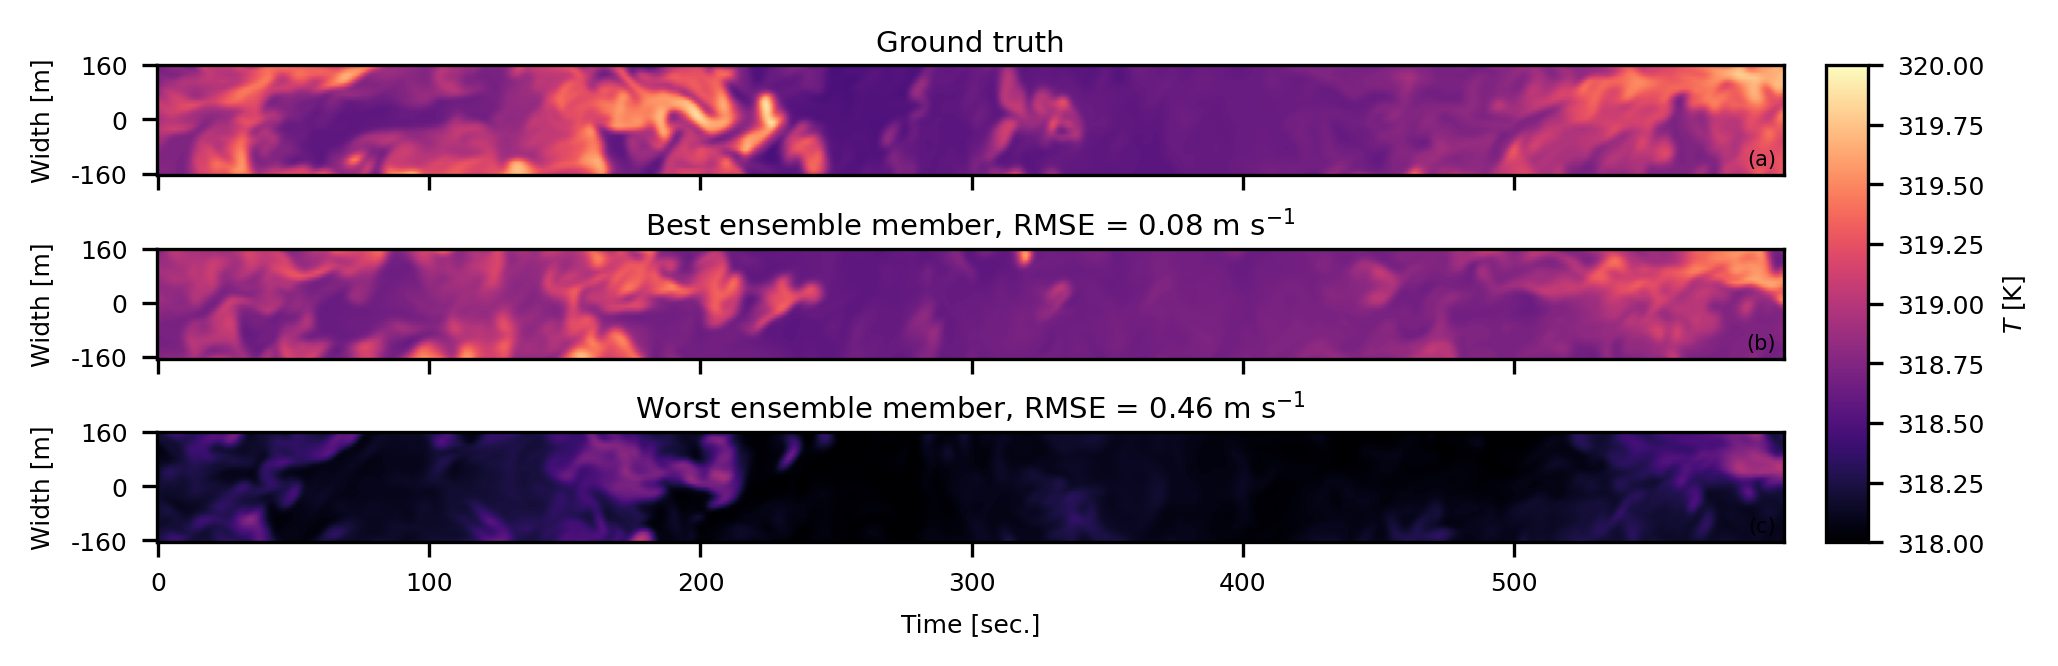

In [11]:
### Top-down views of v/w/T (no constraint panel)
fig, ax = plt.subplots(3, 1, figsize=(7,2.25), dpi=300, sharex=True)


## Plot
# pltvar = 'velocityy'
# pltmin, pltmax = -3.5, 3.5
# cmap = 'RdBu_r'
# cbar_label = '$v$ [m s$^{-1}$]'
# pltvar = 'velocityz'
# pltmin, pltmax = -3., 3.
# cmap = 'RdBu_r'
# cbar_label = '$w$ [m s$^{-1}$]'
pltvar = 'temperature'
pltmin, pltmax = 318., 320.
cmap = 'magma'
cbar_label = '$T$ [K]'

ds_gt_plt = ds_gt1
ds_recon_plt = ds_recon1
ds_lidar_plt = ds_lidar1
zplt = 110
tlo = 0
thi = tlo + 600

# Calculate best/worst ensemble member
rmse_ens_plt = np.mean((ds_recon_plt[pltvar] - ds_gt_plt[pltvar])**2, axis=(1,2,3)).values
iens_best = np.argmin(rmse_ens_plt)
iens_worst = np.argmax(rmse_ens_plt)

data0 = ds_gt_plt[pltvar].sel(z=zplt).isel(time=slice(tlo,thi)).values
data1 = ds_recon_plt[pltvar].sel(z=zplt).isel(ens=iens_best).isel(time=slice(tlo,thi)).values
data2 = ds_recon_plt[pltvar].sel(z=zplt).isel(ens=iens_worst).isel(time=slice(tlo,thi)).values


im0 = ax[0].imshow(data0.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax,
                   cmap=cmap,
                   aspect=1.25)
im1 = ax[1].imshow(data1.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax,
                   cmap=cmap,
                   aspect=1.25)
im2 = ax[2].imshow(data2.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax,
                   cmap=cmap,
                   aspect=1.25)


## Decorate
ax[0].set_title("Ground truth",fontsize=7,y=0.90)
ax[1].set_title(f"Best ensemble member, RMSE = {rmse_ens_plt[iens_best]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.90)
ax[2].set_title(f"Worst ensemble member, RMSE = {rmse_ens_plt[iens_worst]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.90)
ax[-1].set_xlabel("Time [sec.]",fontsize=6,y=0.90)

for axs in ax:
    yticks = np.array((0, 16, 32))
    axs.set_yticks(yticks)
    axs.set_yticklabels(10*yticks-160)
    axs.set_ylabel("Width [m]",fontsize=6)
    axs.tick_params(axis='both',labelsize=6)

## Colorbar
cax0 = fig.add_axes([ax[-1].get_position().x1+0.02,
                     ax[-1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[-1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label(cbar_label, fontsize=6)
cbar0.ax.tick_params(labelsize=6)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.995,
          0.09,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='k')

# plt.savefig('figs/osse1_qualitative_topdown_view_v.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/osse1_qualitative_topdown_view_w.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/osse1_qualitative_topdown_view_temp.png', bbox_inches='tight', dpi=1000)
    
# plt.savefig('figs/osse2_qualitative_topdown_view_v.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/osse2_qualitative_topdown_view_w.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/osse2_qualitative_topdown_view_temp.png', bbox_inches='tight', dpi=1000)

plt.show()

### Side views

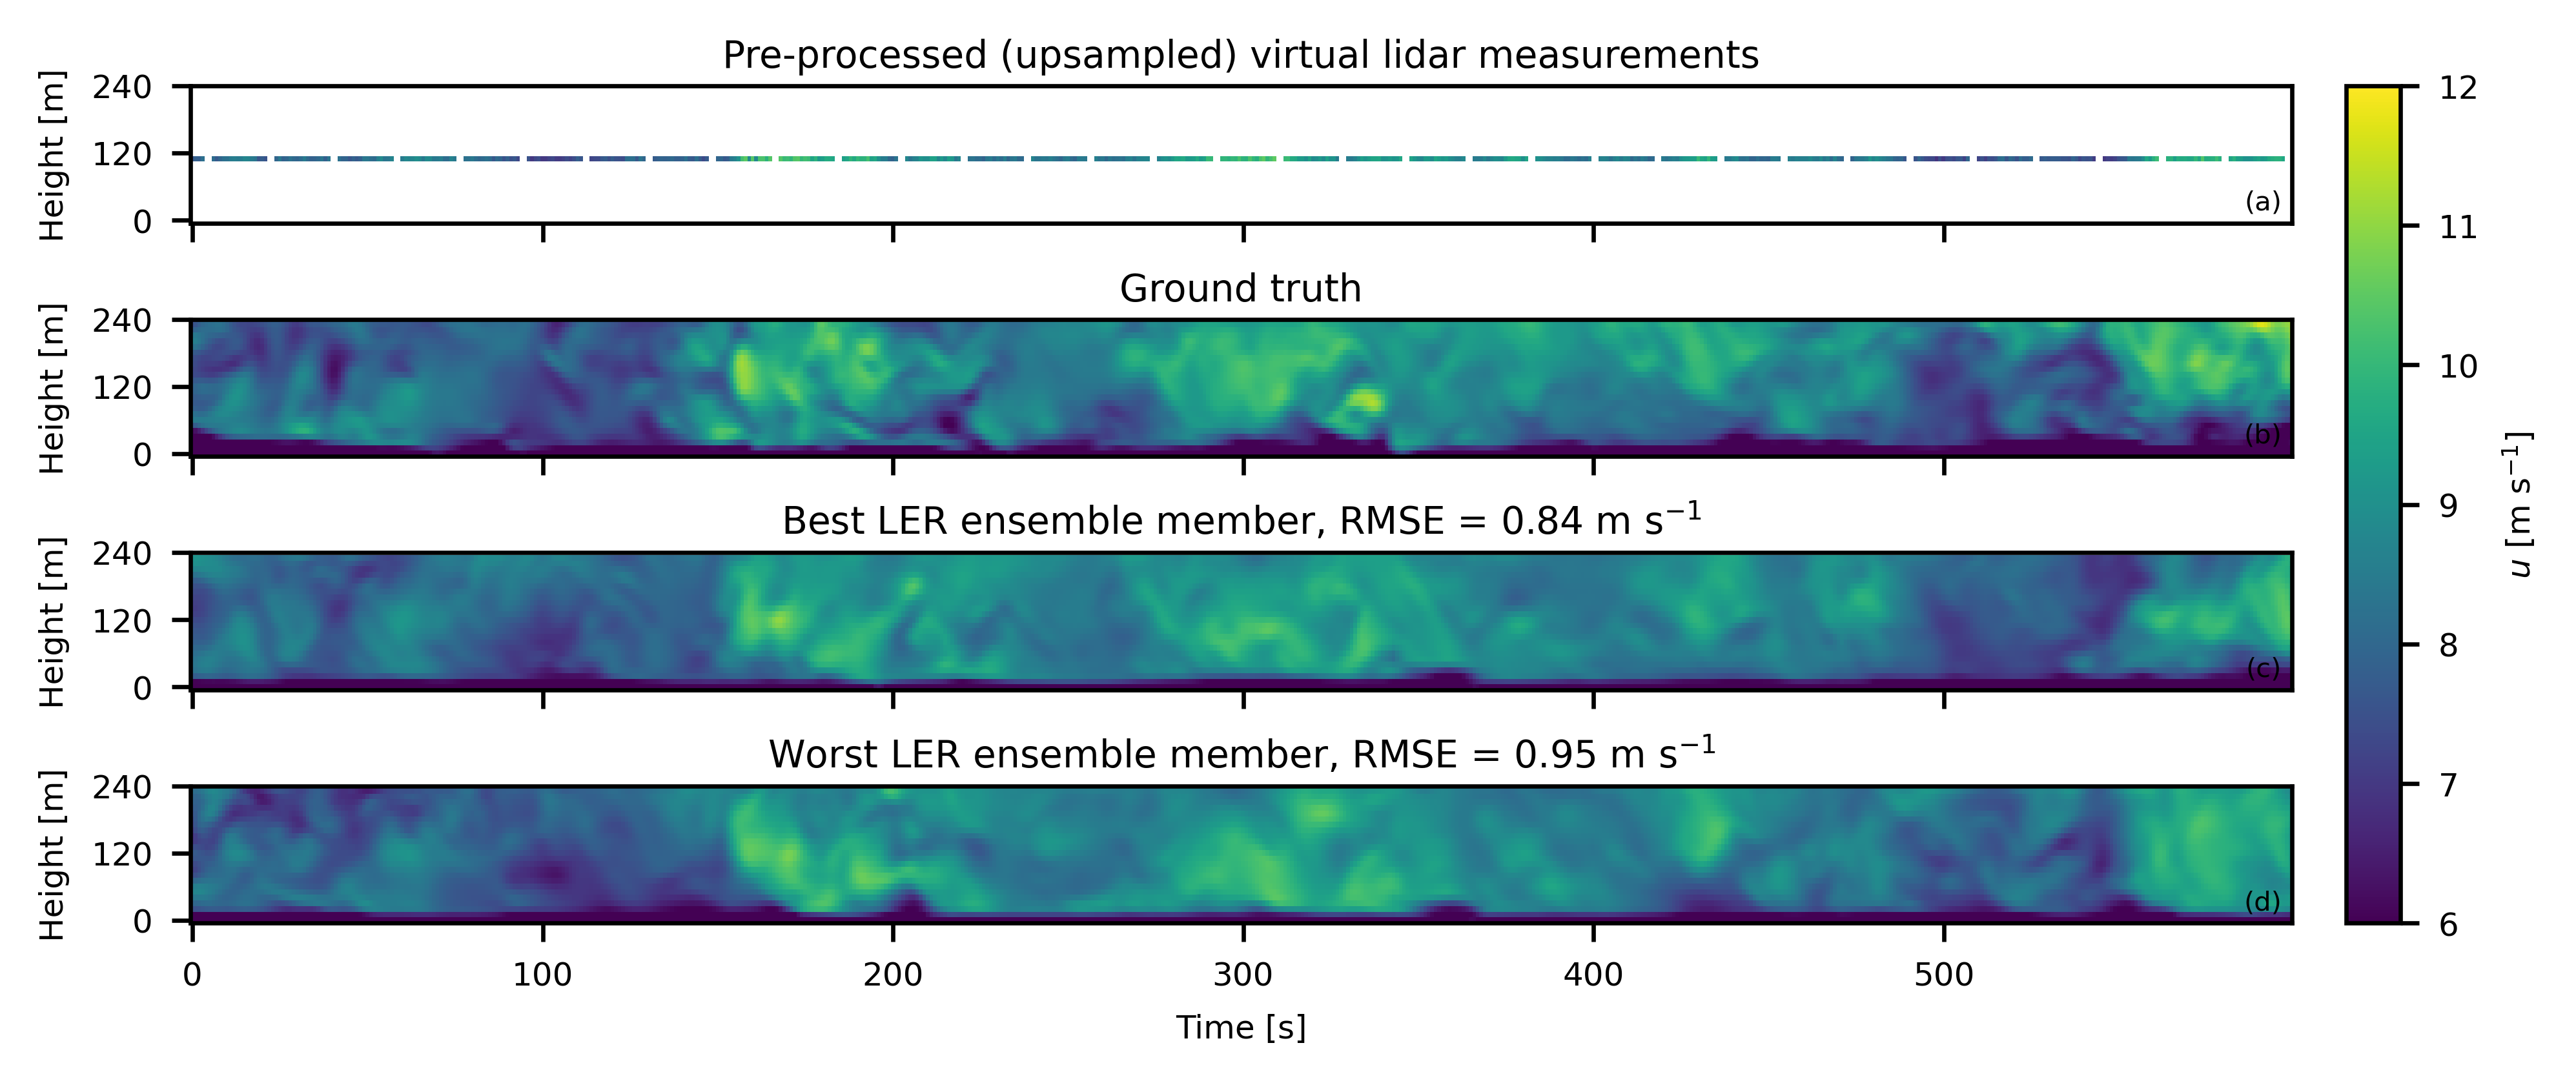

In [12]:
### Side views
fig, ax = plt.subplots(4, 1, figsize=(7,3), dpi=600, sharex=True)


## Plot
pltvar = 'velocityx'
pltmin, pltmax = 6, 12
ds_gt_plt = ds_gt1
ds_recon_plt = ds_recon1
ds_lidar_plt = ds_lidar1
yplt = 0
tlo = 0
thi = tlo + 600

# Calculate best/worst ensemble member
rmse_ens_plt = np.mean((ds_recon_plt[pltvar] - ds_gt_plt[pltvar])**2, axis=(1,2,3)).values
iens_best = np.argmin(rmse_ens_plt)
iens_worst = np.argmax(rmse_ens_plt)

data0 = ds_lidar_plt['velocityx'].sel(y=yplt).isel(time=slice(tlo,thi)).values
data1 = ds_gt_plt[pltvar].sel(y=yplt).isel(time=slice(tlo,thi)).values
data2 = ds_recon_plt[pltvar].sel(y=yplt).isel(ens=iens_best).isel(time=slice(tlo,thi)).values
data3 = ds_recon_plt[pltvar].sel(y=yplt).isel(ens=iens_worst).isel(time=slice(tlo,thi)).values


im0 = ax[0].imshow(data0.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax,
                   aspect=1.6)
im1 = ax[1].imshow(data1.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax,
                   aspect=1.6)
im2 = ax[2].imshow(data2.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax,
                   aspect=1.6)
im3 = ax[3].imshow(data3.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax,
                   aspect=1.6)


## Decorate
ax[0].set_title("Pre-processed (upsampled) virtual lidar measurements",fontsize=7,y=0.9)
ax[1].set_title("Ground truth",fontsize=7,y=0.9)
ax[2].set_title(f"Best LER ensemble member, RMSE = {rmse_ens_plt[iens_best]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.9)
ax[3].set_title(f"Worst LER ensemble member, RMSE = {rmse_ens_plt[iens_worst]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.9)
ax[-1].set_xlabel("Time [s]",fontsize=6)

for axs in ax:
    yticks = np.array((0, 12, 24))
    axs.set_yticks(yticks)
    axs.set_yticklabels(10*yticks)
    axs.set_ylabel("Height [m]",fontsize=6)
    axs.tick_params('both',labelsize=6)

## Colorbar
cax0 = fig.add_axes([ax[-1].get_position().x1+0.02,
                     ax[-1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[-1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('$u$ [m s$^{-1}$]', fontsize=6)
cbar0.ax.tick_params(labelsize=6)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.995,
          0.099,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='k')

# plt.savefig('figs/osse_qualitative_side_view.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/osse1_qualitative_side_view.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/osse2_qualitative_side_view.png', bbox_inches='tight', dpi=1000)
# plt.savefig('figs/osse_qualitative_side_view.pdf', bbox_inches='tight')
    
plt.show()

### Time series at rotor bottom, hub-height, and rotor top

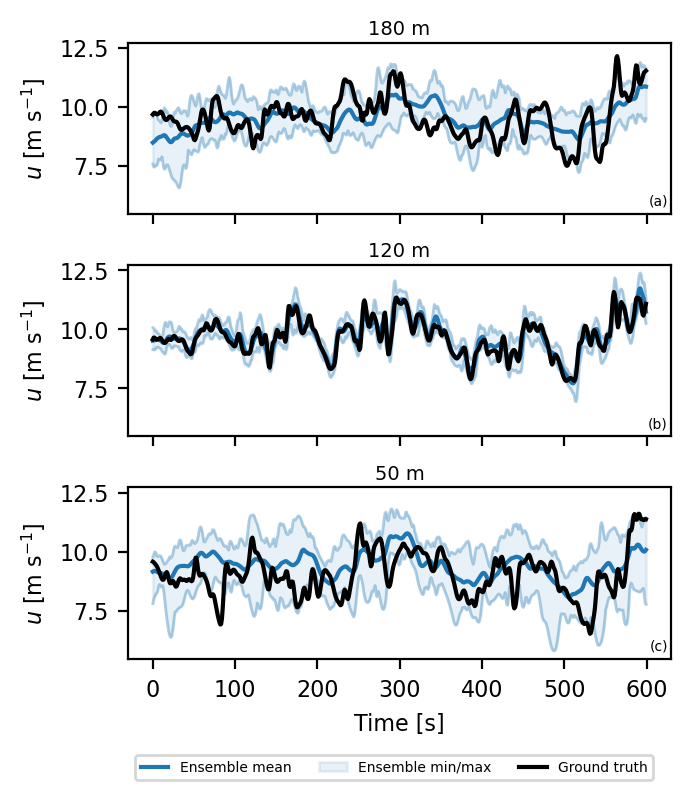

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(3.5,4), dpi=200, sharex=True, sharey=True)

pltvar = 'velocityx'

ds_gt_plt = ds_gt2
ds_recon_plt = ds_recon2

for icol, zplt in enumerate([180, 120, 50]):
    ax[icol].plot(ds_recon_plt['time'],
                     ds_recon_plt[pltvar].sel(z=zplt,y=0).mean('ens'),
                     color='C0',
                     label='Ensemble mean')
    ax[icol].plot(ds_recon_plt['time'],
                     ds_recon_plt[pltvar].sel(z=zplt,y=0).max('ens'),
                     color='C0',
                     alpha=0.3,
                     linewidth=1)
    ax[icol].plot(ds_recon_plt['time'],
                     ds_recon_plt[pltvar].sel(z=zplt,y=0).min('ens'),
                     color='C0',
                     alpha=0.3,
                     linewidth=1)
    ax[icol].fill_between(ds_recon_plt['time'],
                     ds_recon_plt[pltvar].sel(z=zplt,y=0).min('ens'),
                     ds_recon_plt[pltvar].sel(z=zplt,y=0).max('ens'),
                     color='C0',
                     alpha=0.1,
                     label='Ensemble min/max')

    ax[icol].plot(ds_gt_plt['time'],
                     ds_gt_plt[pltvar].sel(z=zplt,y=0),
                     color='k',
                     label='Ground truth')


for axs in ax.flatten():
    axs.tick_params('both',labelsize=8)
    
for axs in ax:
    axs.set_ylabel("$u$ [m s$^{-1}$]", fontsize=8)
ax[-1].set_xlabel("Time [s]", fontsize=8)
        
ax[0].set_title("180 m", fontsize=7, y=0.95)
ax[1].set_title("120 m", fontsize=7, y=0.95)
ax[2].set_title("50 m", fontsize=7, y=0.95)
plt.subplots_adjust(hspace=0.3)

handles, labels = ax[-1].get_legend_handles_labels()
lgd = ax[-1].legend(handles, labels, bbox_to_anchor=(0.0, -0.75), loc='lower left', fontsize=5, ncol=3)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.995,
          0.05,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='k')

# plt.savefig('figs/osse_timeseries_centerline.pdf', bbox_inches='tight')
        
# ax[1].set_xlim(300,400)
    
plt.show()

# Quantitative comparisons

### Pearson correlation profiles

ens mean u correlation profile values [0.41926968 0.57443148 0.51713371 0.48902169 0.52404524 0.58410028
 0.65462804 0.74170798 0.82661704 0.89277274 0.93399313 0.96176287
 0.96471635 0.92160534 0.85250429 0.79518392 0.76240028 0.73815157
 0.71342382 0.69305572 0.66259266 0.62933236 0.60073469 0.58730848]
ens mean u correlation profile values [0.08265307 0.17933748 0.1636021  0.21164326 0.230848   0.26128161
 0.32093582 0.44647817 0.59279505 0.71978057 0.83743498 0.92860612
 0.94302053 0.90005828 0.84299477 0.8074486  0.78421123 0.76121703
 0.73484111 0.69987683 0.65907368 0.6060206  0.54118322 0.48393151]
ens mean u correlation profile values [0.14514717 0.2449995  0.25585973 0.30586099 0.33748587 0.35752289
 0.39030056 0.43288603 0.4980789  0.60522136 0.75784446 0.88790245
 0.91674382 0.86407305 0.77602085 0.6727235  0.57032949 0.49369465
 0.43180349 0.36737564 0.31190484 0.26597689 0.22601085 0.19852623]


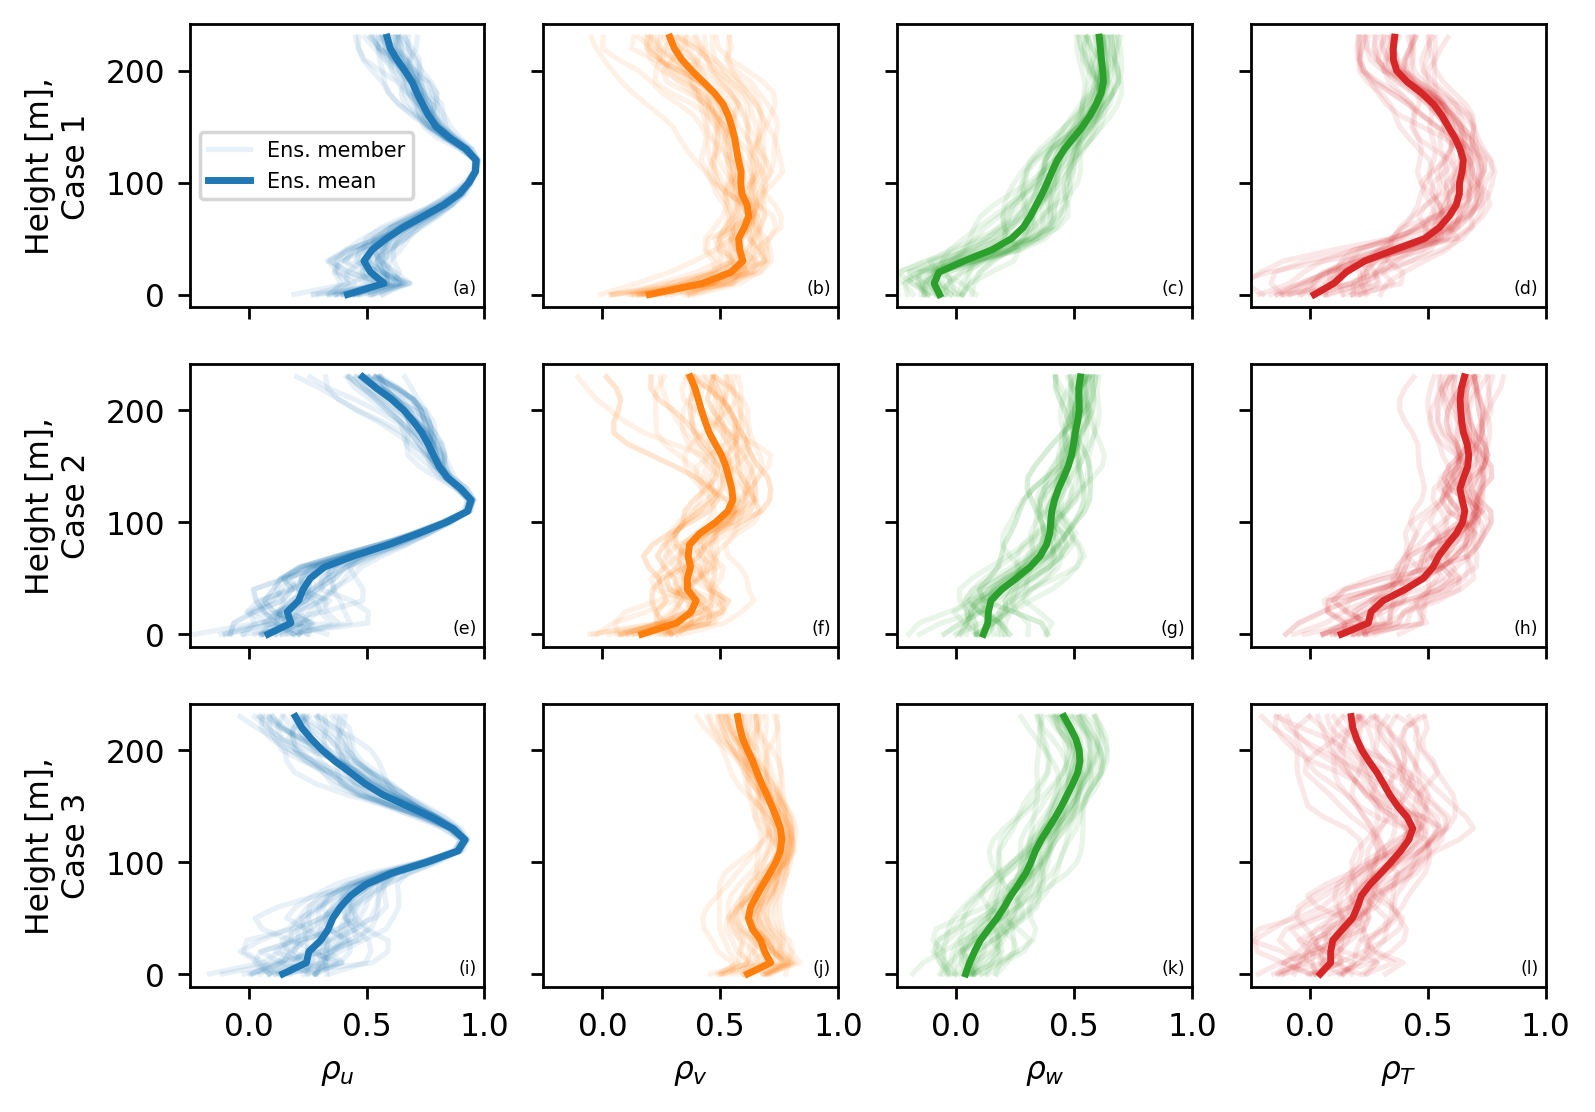

In [16]:
### Correlations at one y location
fig, ax = plt.subplots(3, 4, figsize=(7,5), dpi=250, sharey=True, sharex=True)

for axs in ax.flatten():
    axs.set_xlim(-0.25,1)
    axs.tick_params(labelsize=9)
ax[0,0].set_ylabel("Height [m],\nCase 1", fontsize=9)
ax[1,0].set_ylabel("Height [m],\nCase 2", fontsize=9)
ax[2,0].set_ylabel("Height [m],\nCase 3", fontsize=9)
ax[-1,0].set_xlabel('$\\rho_u$', fontsize=9)
ax[-1,1].set_xlabel('$\\rho_v$', fontsize=9)
ax[-1,2].set_xlabel('$\\rho_w$', fontsize=9)
ax[-1,3].set_xlabel('$\\rho_T$', fontsize=9)
# ax[4].set_xlabel('$\\rho_{SGS_{TKE}}$')
    
curr_y = 0
for icase, ds_gt, ds_recon in zip((0,1,2), (ds_gt0, ds_gt1, ds_gt2), (ds_recon0, ds_recon1, ds_recon2)):

    corr_uprofile = np.zeros((len(ds_gt['z']), len(ds_recon['ens'])))
    corr_vprofile = np.zeros((len(ds_gt['z']), len(ds_recon['ens'])))
    corr_wprofile = np.zeros((len(ds_gt['z']), len(ds_recon['ens'])))
    corr_Tprofile = np.zeros((len(ds_gt['z']), len(ds_recon['ens'])))
    corr_TKEprofile = np.zeros((len(ds_gt['z']), len(ds_recon['ens'])))
    for k, z in enumerate(ds_gt0['z']):
        corr_uprofile[k,:] = xr.corr(ds_gt['velocityx'].sel(y=curr_y,z=z), ds_recon['velocityx'].sel(y=curr_y,z=z), dim='time').values[:].copy()
        corr_vprofile[k,:] = xr.corr(ds_gt['velocityy'].sel(y=curr_y,z=z), ds_recon['velocityy'].sel(y=curr_y,z=z), dim='time').values[:].copy()
        corr_wprofile[k,:] = xr.corr(ds_gt['velocityz'].sel(y=curr_y,z=z), ds_recon['velocityz'].sel(y=curr_y,z=z), dim='time').values[:].copy()
        corr_Tprofile[k,:] = xr.corr(ds_gt['temperature'].sel(y=curr_y,z=z), ds_recon['temperature'].sel(y=curr_y,z=z), dim='time').values[:].copy()
        corr_TKEprofile[k,:] = xr.corr(ds_gt['tke'].sel(y=curr_y,z=z), ds_recon['tke'].sel(y=curr_y,z=z), dim='time').values[:].copy()

    ax[icase,0].plot(corr_uprofile,
               ds_gt0['z'],
               color='C0',
               alpha=0.1,
               label='Ens. member')
    ax[icase,0].plot(corr_uprofile.mean(axis=1),
               ds_gt0['z'],
               color='C0',
               linewidth=2,
               label='Ens. mean')

    ax[icase,1].plot(corr_vprofile,
               ds_gt0['z'],
               color='C1',
               alpha=0.1)
    ax[icase,1].plot(corr_vprofile.mean(axis=1),
               ds_gt0['z'],
               color='C1',
               linewidth=2)

    ax[icase,2].plot(corr_wprofile,
               ds_gt0['z'],
               color='C2',
               alpha=0.1)
    ax[icase,2].plot(corr_wprofile.mean(axis=1),
               ds_gt0['z'],
               color='C2',
               linewidth=2)

    ax[icase,3].plot(corr_Tprofile,
               ds_gt0['z'],
               color='C3',
               alpha=0.1)
    ax[icase,3].plot(corr_Tprofile.mean(axis=1),
               ds_gt0['z'],
               color='C3',
               linewidth=2)

    # ax[icase,4].plot(corr_TKEprofile,
    #            ds_gt0['z'],
    #            color='C4',
    #            alpha=0.2)
    # ax[icase,4].plot(corr_TKEprofile.mean(axis=1),
    #            ds_gt0['z'],
    #            color='C4',
    #            linewidth=3)
    
    print("ens mean u correlation profile values", corr_uprofile.mean(axis=1))

    
handles, labels = ax[0,0].get_legend_handles_labels()
last_two_handles = handles[-2:]
last_two_labels = labels[-2:]
ax[0,0].legend(last_two_handles, last_two_labels, fontsize=6)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.975,
          0.049,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='k')

# plt.savefig('figs/osse_correlation_profiles_all_cases_centerline.pdf', bbox_inches='tight')
plt.show()

ens mean u correlation profile values [0.26666881 0.43543332 0.45085415 0.49936896 0.53502886 0.57177008
 0.61619289 0.6787283  0.75109417 0.81705112 0.86699945 0.9008041
 0.90582745 0.87530785 0.82188013 0.76703669 0.72191988 0.68143561
 0.64781912 0.62223399 0.60100583 0.58335038 0.56019966 0.52678571]
ens mean u correlation profile values [0.20749228 0.3753122  0.40741364 0.46540632 0.51275962 0.54451103
 0.57074378 0.6085312  0.66449145 0.73204093 0.80403771 0.86009459
 0.87089952 0.83897434 0.78476054 0.73362814 0.69255539 0.64923672
 0.60121048 0.54940202 0.50040859 0.45711669 0.41950226 0.38968695]
ens mean u correlation profile values [0.18955063 0.34528718 0.33220422 0.34361379 0.37561417 0.41024051
 0.4386835  0.47257626 0.52831898 0.60866513 0.70618568 0.78877437
 0.80419347 0.75034997 0.66068809 0.56964972 0.48694437 0.41684956
 0.35779708 0.31026638 0.27850522 0.25951548 0.25245652 0.25680381]


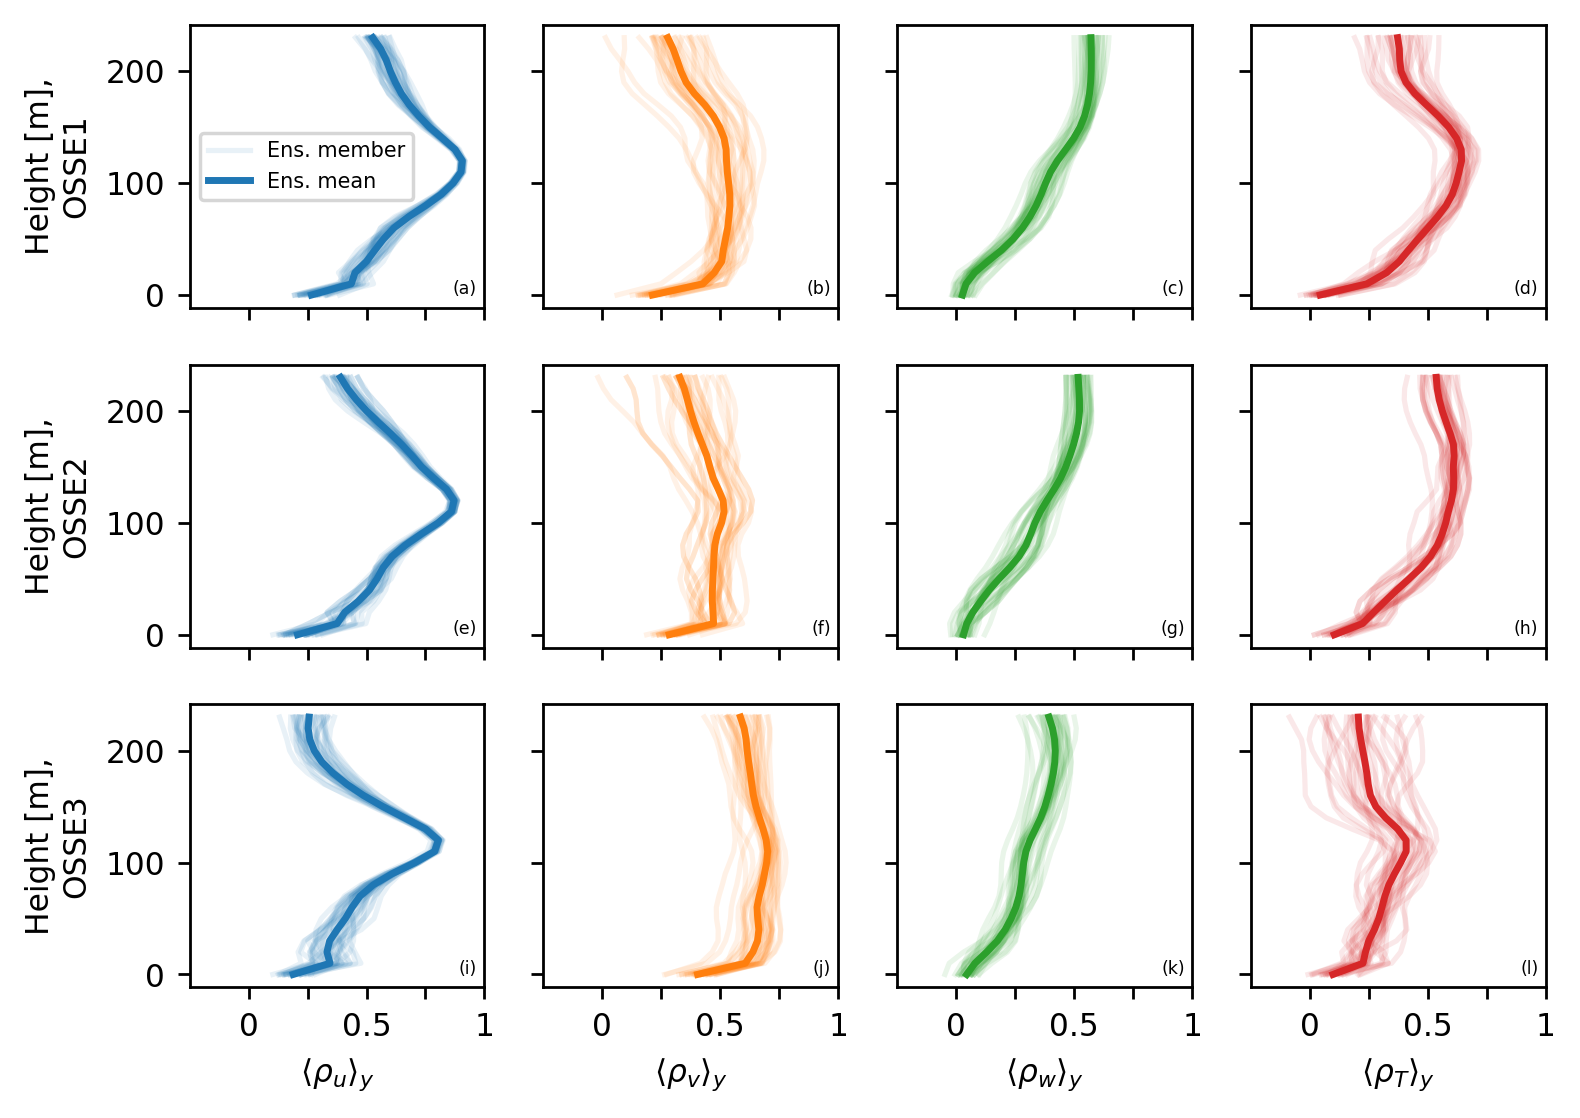

In [17]:
### Correlations at all y locations
fig, ax = plt.subplots(3, 4, figsize=(7,5), dpi=250, sharey=True, sharex=True)

for axs in ax.flatten():
    axs.set_xlim(-0.25,1)
    axs.tick_params(labelsize=9)
ax[0,0].set_ylabel("Height [m],\nOSSE1", fontsize=9)
ax[1,0].set_ylabel("Height [m],\nOSSE2", fontsize=9)
ax[2,0].set_ylabel("Height [m],\nOSSE3", fontsize=9)
ax[-1,0].set_xlabel('$\langle \\rho_u \\rangle_y$', fontsize=9)
ax[-1,1].set_xlabel('$\langle \\rho_v \\rangle_y$', fontsize=9)
ax[-1,2].set_xlabel('$\langle \\rho_w \\rangle_y$', fontsize=9)
ax[-1,3].set_xlabel('$\langle \\rho_T \\rangle_y$', fontsize=9)
# ax[4].set_xlabel('$\\rho_{SGS_{TKE}}$')
    
curr_y = 0
for icase, ds_gt, ds_recon in zip((0,1,2), (ds_gt0, ds_gt1, ds_gt2), (ds_recon0, ds_recon1, ds_recon2)):

    corr_uprofile = np.zeros((len(ds_gt['z']), len(ds_recon['ens'])))
    corr_vprofile = np.zeros((len(ds_gt['z']), len(ds_recon['ens'])))
    corr_wprofile = np.zeros((len(ds_gt['z']), len(ds_recon['ens'])))
    corr_Tprofile = np.zeros((len(ds_gt['z']), len(ds_recon['ens'])))
    corr_TKEprofile = np.zeros((len(ds_gt['z']), len(ds_recon['ens'])))
    for k, z in enumerate(ds_gt0['z']):
        corr_uprofile[k,:] = xr.corr(ds_gt['velocityx'].sel(z=z), ds_recon['velocityx'].sel(z=z), dim='time').mean('y').values[:].copy()
        corr_vprofile[k,:] = xr.corr(ds_gt['velocityy'].sel(z=z), ds_recon['velocityy'].sel(z=z), dim='time').mean('y').values[:].copy()
        corr_wprofile[k,:] = xr.corr(ds_gt['velocityz'].sel(z=z), ds_recon['velocityz'].sel(z=z), dim='time').mean('y').values[:].copy()
        corr_Tprofile[k,:] = xr.corr(ds_gt['temperature'].sel(z=z), ds_recon['temperature'].sel(z=z), dim='time').mean('y').values[:].copy()
        corr_TKEprofile[k,:] = xr.corr(ds_gt['tke'].sel(z=z), ds_recon['tke'].sel(z=z), dim='time').mean('y').values[:].copy()

    ax[icase,0].plot(corr_uprofile,
               ds_gt0['z'],
               color='C0',
               alpha=0.1,
               label='Ens. member')
    ax[icase,0].plot(corr_uprofile.mean(axis=1),
               ds_gt0['z'],
               color='C0',
               linewidth=2,
               label='Ens. mean')

    ax[icase,1].plot(corr_vprofile,
               ds_gt0['z'],
               color='C1',
               alpha=0.1)
    ax[icase,1].plot(corr_vprofile.mean(axis=1),
               ds_gt0['z'],
               color='C1',
               linewidth=2)

    ax[icase,2].plot(corr_wprofile,
               ds_gt0['z'],
               color='C2',
               alpha=0.1)
    ax[icase,2].plot(corr_wprofile.mean(axis=1),
               ds_gt0['z'],
               color='C2',
               linewidth=2)

    ax[icase,3].plot(corr_Tprofile,
               ds_gt0['z'],
               color='C3',
               alpha=0.1)
    ax[icase,3].plot(corr_Tprofile.mean(axis=1),
               ds_gt0['z'],
               color='C3',
               linewidth=2)

    # ax[icase,4].plot(corr_TKEprofile,
    #            ds_gt0['z'],
    #            color='C4',
    #            alpha=0.2)
    # ax[icase,4].plot(corr_TKEprofile.mean(axis=1),
    #            ds_gt0['z'],
    #            color='C4',
    #            linewidth=3)
    
    print("ens mean u correlation profile values", corr_uprofile.mean(axis=1))

    
handles, labels = ax[0,0].get_legend_handles_labels()
last_two_handles = handles[-2:]
last_two_labels = labels[-2:]
ax[0,0].legend(last_two_handles, last_two_labels, fontsize=6)

ax[0,0].set_xticks([0, 0.25, 0.5, 0.75, 1])
ax[0,0].set_xticklabels([0, None, 0.5, None, 1])


## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.975,
          0.049,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='k')

# plt.savefig('figs/osse_correlation_profiles_all_cases_averaged_over_y.pdf', bbox_inches='tight')
plt.show()

# Profiles

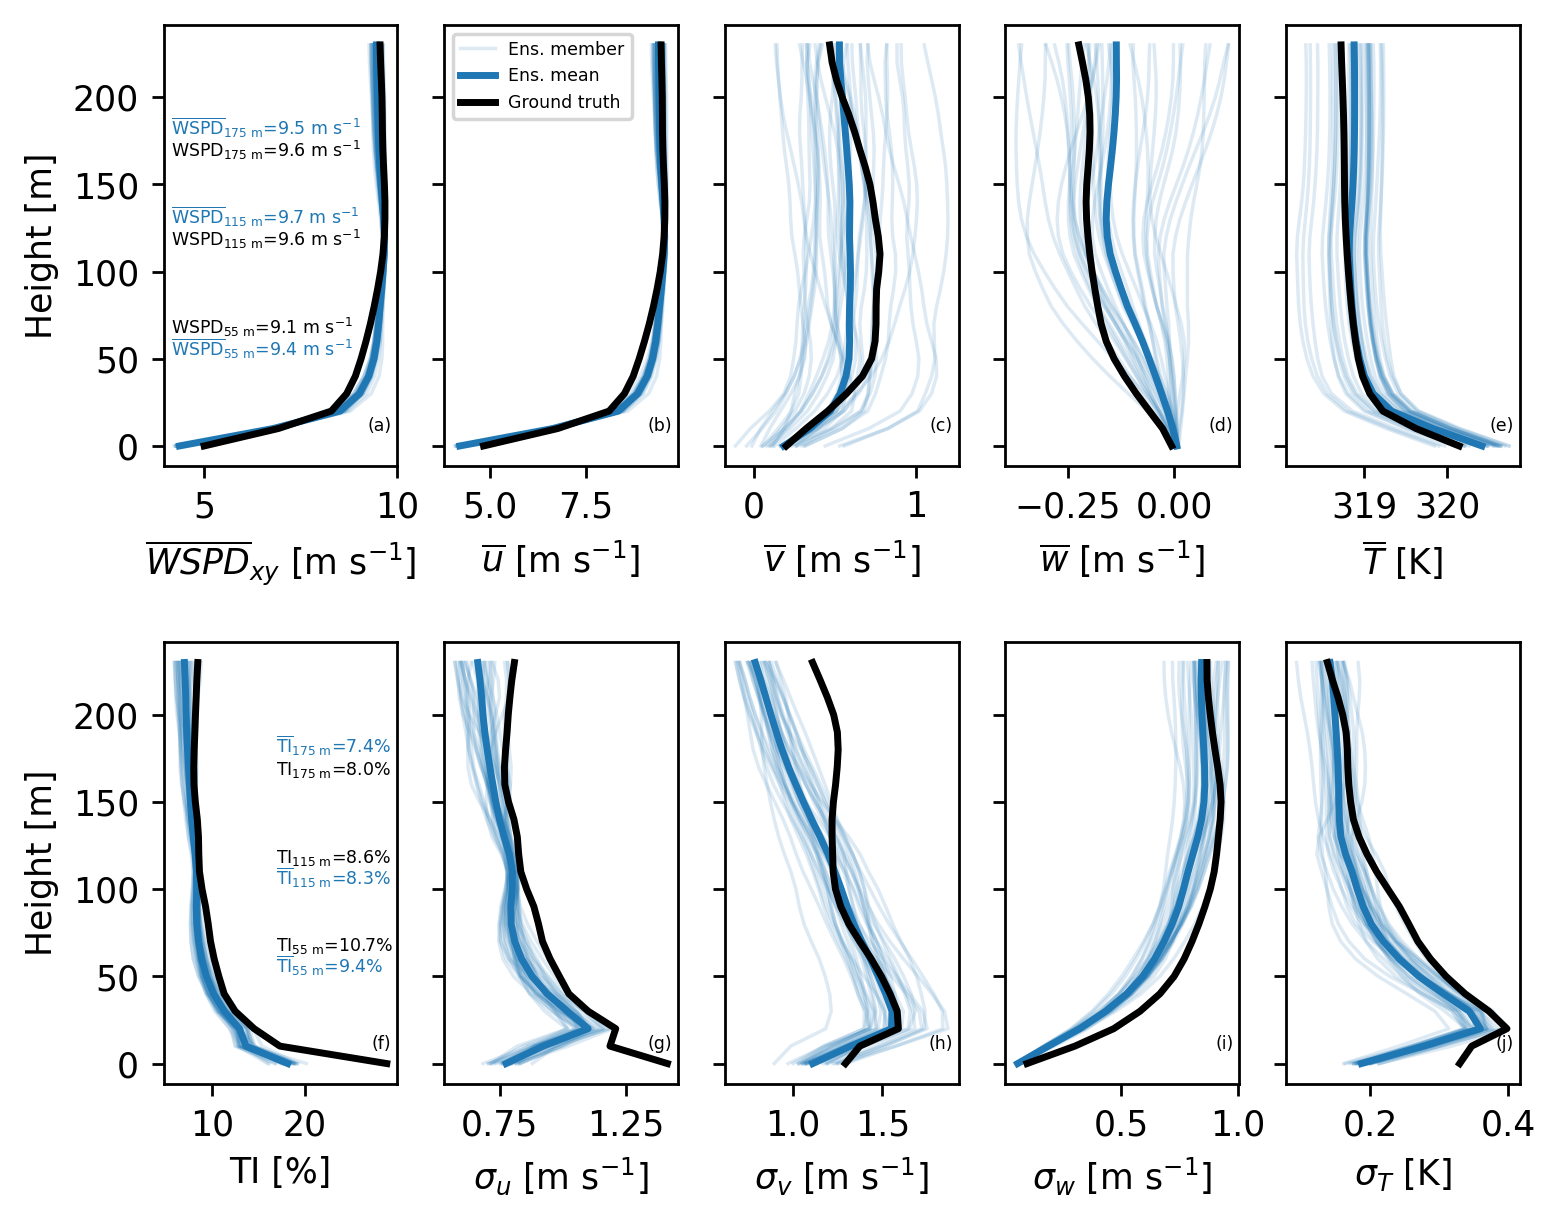

In [19]:
### Profiles of direct variables
fig, ax = plt.subplots(2, 5, figsize=(7,5.5), dpi=250, sharey=True)

ds_gt_plt = ds_gt2
ds_recon_plt = ds_recon2

## Means
for iax, pltvar in enumerate(['wspd_2d', 'velocityx', 'velocityy', 'velocityz', 'temperature']):
    ## Plot reconstructions
    for iens in range(len(ds_recon_plt['ens'])):
        ax[0,iax].plot(ds_recon_plt[pltvar].isel(ens=iens).mean(('time', 'y')),
                     ds_recon_plt['z'],
                     color='C0',
                     linewidth=1,
                     alpha=0.15,
                     label='Ens. member')
    ax[0,iax].plot(ds_recon_plt[pltvar].mean(('time', 'y')).mean('ens'),
                 ds_recon_plt['z'],
                 color='C0',
                 linewidth=2,
                 label='Ens. mean')
        
    ## Plot ground truth
    ax[0,iax].plot(ds_gt_plt[pltvar].mean(('time', 'y')),
                 ds_gt_plt['z'],
                 color='k',
                 linewidth=2,
                 label='Ground truth')

## Standard deviations
for iax, pltvar in enumerate(['velocityx', 'velocityy', 'velocityz', 'temperature']):
    ## Plot reconstructions
    for iens in range(len(ds_recon_plt['ens'])):
        # ax[1,iax+1].plot(ds_recon_plt[pltvar].isel(ens=iens).std(('time', 'y')),
        ax[1,iax+1].plot(ds_recon_plt[pltvar].isel(ens=iens).std('time').mean('y'),
                     ds_recon_plt['z'],
                     color='C0',
                     linewidth=1,
                     alpha=0.15,
                     label='Ens. member')
    ax[1,iax+1].plot(ds_recon_plt[pltvar].std('time').mean(('y','ens')),
                 ds_recon_plt['z'],
                 color='C0',
                 linewidth=2,
                 label='Ens. mean')
        
    ## Plot ground truth
    ax[1,iax+1].plot(ds_gt_plt[pltvar].std('time').mean('y'),
                 ds_gt_plt['z'],
                 color='k',
                 linewidth=2,
                 label='Ground truth')
    
## Turbulence intensity
for iens in range(len(ds_recon_plt['ens'])):
    ax[1,0].plot(ds_recon_plt['TI'].isel(ens=iens),
                 ds_recon_plt['z'],
                 color='C0',
                 linewidth=1,
                 alpha=0.15,
                 label='Ens. member')
ax[1,0].plot(ds_recon_plt['TI'].mean('ens'),
             ds_recon_plt['z'],
             color='C0',
             linewidth=2,
             label='Ens. mean')

## Plot ground truth
ax[1,0].plot(ds_gt_plt['TI'],
             ds_gt_plt['z'],
             color='k',
             linewidth=2,
             label='Ground truth')
    
## Decorate
ax[0,0].set_ylabel("Height [m]")
ax[0,0].set_xlabel("$\overline{WSPD}_{xy}$ [m s$^{-1}$]")
ax[0,1].set_xlabel("$\overline{u}$ [m s$^{-1}$]")
ax[0,2].set_xlabel("$\overline{v}$ [m s$^{-1}$]")
ax[0,3].set_xlabel("$\overline{w}$ [m s$^{-1}$]")
ax[0,4].set_xlabel("$\overline{T}$ [K]")

ax[1,0].set_ylabel("Height [m]")
ax[1,0].set_xlabel("TI [%]")
ax[1,1].set_xlabel("$\sigma_u$ [m s$^{-1}$]")
ax[1,2].set_xlabel("$\sigma_v$ [m s$^{-1}$]")
ax[1,3].set_xlabel("$\sigma_w$ [m s$^{-1}$]")
ax[1,4].set_xlabel("$\sigma_T$ [K]")
# ax[4].set_xlabel("TKE [m$^2$ s$^{-2}$]")

ax[1,1].set_xticks([0.75, 1.25])

## Write out specific values
# Mean
ax[0,0].text(0.03,
      0.30,
      'WSPD$_{55\\text{ m}}$='+f'{ds_gt_plt["wspd_2d"].sel(z=50).mean(("time", "y")).values:.1f} '+'m s$^{-1}$',
      fontsize=5,
      transform = ax[0,0].transAxes,
      horizontalalignment='left',
        color='k')
ax[0,0].text(0.03,
      0.25,
      '$\overline{\\text{WSPD}}_{55\\text{ m}}$='+f'{ds_recon_plt["wspd_2d"].sel(z=50).mean(("ens", "y", "time")).values:.1f} '+'m s$^{-1}$',
      fontsize=5,
      transform = ax[0,0].transAxes,
      horizontalalignment='left',
        color='C0')

ax[0,0].text(0.03,
      0.50,
      'WSPD$_{115\\text{ m}}$='+f'{ds_gt_plt["wspd_2d"].sel(z=110).mean(("time", "y")).values:.1f} '+'m s$^{-1}$',
      fontsize=5,
      transform = ax[0,0].transAxes,
      horizontalalignment='left',
        color='k')
ax[0,0].text(0.03,
      0.55,
      '$\overline{\\text{WSPD}}_{115\\text{ m}}$='+f'{ds_recon_plt["wspd_2d"].sel(z=110).mean(("ens", "y", "time")).values:.1f} '+'m s$^{-1}$',
      fontsize=5,
      transform = ax[0,0].transAxes,
      horizontalalignment='left',
        color='C0')

ax[0,0].text(0.03,
      0.70,
      'WSPD$_{175\\text{ m}}$='+f'{ds_gt_plt["wspd_2d"].sel(z=170).mean(("time", "y")).values:.1f} '+'m s$^{-1}$',
      fontsize=5,
      transform = ax[0,0].transAxes,
      horizontalalignment='left',
        color='k')
ax[0,0].text(0.03,
      0.75,
      '$\overline{\\text{WSPD}}_{175\\text{ m}}$='+f'{ds_recon_plt["wspd_2d"].sel(z=170).mean(("ens", "y", "time")).values:.1f} '+'m s$^{-1}$',
      fontsize=5,
      transform = ax[0,0].transAxes,
      horizontalalignment='left',
        color='C0')

# Turbulence intensity
ax[1,0].text(0.48,
      0.30,
      'TI$_{55\\text{ m}}$='+f'{ds_gt_plt["TI"].sel(z=50).values:.1f}%',
      fontsize=5,
      transform = ax[1,0].transAxes,
      horizontalalignment='left',
        color='k')
ax[1,0].text(0.48,
      0.25,
      '$\overline{\\text{TI}}_{55\\text{ m}}$='+f'{ds_recon_plt["TI"].sel(z=50).mean("ens").values:.1f}%',
      fontsize=5,
      transform = ax[1,0].transAxes,
      horizontalalignment='left',
        color='C0')

ax[1,0].text(0.48,
      0.50,
      'TI$_{115\\text{ m}}$='+f'{ds_gt_plt["TI"].sel(z=110).values:.1f}%',
      fontsize=5,
      transform = ax[1,0].transAxes,
      horizontalalignment='left',
        color='k')
ax[1,0].text(0.48,
      0.45,
      '$\overline{\\text{TI}}_{115\\text{ m}}$='+f'{ds_recon_plt["TI"].sel(z=110).mean("ens").values:.1f}%',
      fontsize=5,
      transform = ax[1,0].transAxes,
      horizontalalignment='left',
        color='C0')

ax[1,0].text(0.48,
      0.70,
      'TI$_{175\\text{ m}}$='+f'{ds_gt_plt["TI"].sel(z=170).values:.1f}%',
      fontsize=5,
      transform = ax[1,0].transAxes,
      horizontalalignment='left',
        color='k')
ax[1,0].text(0.48,
      0.75,
      '$\overline{\\text{TI}}_{175\\text{ m}}$='+f'{ds_recon_plt["TI"].sel(z=170).mean("ens").values:.1f}%',
      fontsize=5,
      transform = ax[1,0].transAxes,
      horizontalalignment='left',
        color='C0')

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.975,
          0.079,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='k')

plt.subplots_adjust(hspace=0.4)

handles, labels = ax[0,1].get_legend_handles_labels()
ax[0,1].legend(handles[-3:], labels[-3:], fontsize=5)

# plt.savefig('figs/osse_mean_and_std.pdf', bbox_inches='tight')
# plt.savefig('figs/osse2_mean_and_std.pdf', bbox_inches='tight')
        
plt.show()

# Pixel-by-pixel error histograms

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(16, 3), dpi=125)

for axs in ax:
    axs.set_box_aspect(1)
    axs.set_yticks([])
    axs.set_yticklabels([])

ax[0].set_ylabel("Relative count")
ax[0].set_xlabel("$u$ [m s$^{-1}$]")
ax[1].set_xlabel("$v$ [m s$^{-1}$]")
ax[2].set_xlabel("$w$ [m s$^{-1}$]")
ax[3].set_xlabel("$T$ [K]")
ax[4].set_xlabel("TKE [m$^2$ s$^{-2}$]")
plt.suptitle("Pixel-by-pixel reconstruction errors")

allbins = [np.arange(-4, 4+0.125, 0.125),
        np.arange(-4, 4+0.125, 0.125),
        np.arange(-3.5, 3.5+0.125, 0.125),
        np.arange(-1.5, 2.0+0.125, 0.0625),
        np.arange(-0.5, 0.5+0.05, 0.025)]

pltvars = ['velocityx', 'velocityy', 'velocityz', 'temperature', 'tke']

for i, var in enumerate(pltvars):
    for j in range(3):
        err = (eval(f'ds_recon{j}')[var] - eval(f'ds_gt{j}')[var]).values.flatten()
        ax[i].hist(err, bins=allbins[i], edgecolor=f'C{j}', facecolor='none', label=f'Case {j}')
    

plt.show()